## Libraries:

In [1]:
#Core:

import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import requests
import matplotlib.pyplot as plt

#Procesado datos:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Models:

from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Loading Data:

In [2]:
# Loading Clients data:

url_cli_train = 'https://raw.githubusercontent.com/manugaco/ML_User_Cases/master/Datasets/Fraud_detection/client_train.csv'
cli_train = pd.read_csv(url_cli_train, low_memory=False)

url_cli_test = 'https://raw.githubusercontent.com/manugaco/ML_User_Cases/master/Datasets/Fraud_detection/client_test.csv'
cli_test = pd.read_csv(url_cli_test, low_memory=False)

# Loading Invoices data:

url_inv_train = 'https://github.com/manugaco/ML_User_Cases/raw/master/Datasets/Fraud_detection/invoice_train.csv.zip?raw=true'
zip_inv_train = ZipFile(BytesIO(requests.get(url_inv_train).content), 'r')
inv_train = pd.read_csv(zip_inv_train.open(zip_inv_train.namelist()[0]), low_memory=False)

url_inv_test = 'https://github.com/manugaco/ML_User_Cases/blob/master/Datasets/Fraud_detection/invoice_test.csv.zip?raw=true'
url_inv_test = ZipFile(BytesIO(requests.get(url_inv_test).content), 'r')
inv_test = pd.read_csv(url_inv_test.open(url_inv_test.namelist()[0]), low_memory=False)

### Data preview:

In [3]:
print('Clients train dataset dimensions: ', cli_train.shape)
print('Clients test dataset dimensions: ', cli_test.shape)
print('Invoices train dataset dimensions: ', inv_train.shape)
print('Invoices test dataset dimensions: ', inv_test.shape)

Clients train dataset dimensions:  (135493, 6)
Clients test dataset dimensions:  (58069, 5)
Invoices train dataset dimensions:  (4476749, 16)
Invoices test dataset dimensions:  (1939730, 16)


In [4]:
cli_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
inv_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


### Data wrangling:

#### Missing values:

In [6]:
# Check missing values on each column function:

def missing(tabla):
    return [pd.isna(tabla[column]).sum() for column in tabla.columns]

In [7]:
miss = pd.DataFrame(missing(cli_train), index = cli_train.columns).transpose()
miss.index = ['Clients train dataset']
miss

,disrict,client_id,client_catg,region,creation_date,target
Clients train dataset,0,0,0,0,0,0


In [8]:
miss = pd.DataFrame(missing(cli_test), index = cli_test.columns).transpose()
miss.index = ['Clients test dataset']
miss

,disrict,client_id,client_catg,region,creation_date
Clients test dataset,0,0,0,0,0


In [9]:
miss = pd.DataFrame(missing(inv_train), index = inv_train.columns).transpose()
miss.index = ['Invoices train dataset']
miss


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
Invoices train dataset,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
miss = pd.DataFrame(missing(inv_test), index = inv_test.columns).transpose()
miss.index = ['Invoices test dataset']
miss

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
Invoices test dataset,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Duplicated entries:

In [11]:
print('Number of duplicated entries in clients train dataset: ', cli_train.duplicated(subset=['client_id']).sum())
print('Number of duplicated entries in clients test dataset: ',cli_test.duplicated(subset=['client_id']).sum())
print('Number of duplicated entries in invoices train dataset: ', inv_train.duplicated(subset=['client_id','invoice_date','new_index']).sum())
print('Number of duplicated entries in invoices test dataset: ', inv_test.duplicated(subset=['client_id','invoice_date','new_index']).sum())

Number of duplicated entries in clients train dataset:  0
Number of duplicated entries in clients test dataset:  0
Number of duplicated entries in invoices train dataset:  7263
Number of duplicated entries in invoices test dataset:  3004


In [12]:
inv_train = inv_train.drop_duplicates(subset=['client_id','invoice_date','new_index'])
inv_test = inv_test.drop_duplicates(subset=['client_id','invoice_date','new_index'])

#### Train and test id's validation:

In [13]:
val_dis = [(var, len(inv_train[var].value_counts())) for var in inv_train.columns]

In [14]:
len(cli_train['client_id'].value_counts())

135493

In [15]:
len(cli_train['client_id'].value_counts()) == val_dis[0][1]

True

In [16]:
inv_train_gp = inv_train.groupby('client_id').count().reset_index()

In [17]:
inv_train_gp.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
1,train_Client_1,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
2,train_Client_10,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
3,train_Client_100,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
4,train_Client_1000,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14


In [18]:
merged = cli_train.merge(inv_train_gp, on = 'client_id', how = 'inner')
merged.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

In [19]:
len(cli_train['client_id'].value_counts()) == merged.shape[0]

True

In [20]:
val_dis[0][1] == merged.shape[0]

True

In [21]:
# Distinct values on each invoices variable:

val_dis

[('client_id', 135493),
 ('invoice_date', 8275),
 ('tarif_type', 16),
 ('counter_number', 201712),
 ('counter_statue', 11),
 ('counter_code', 41),
 ('reading_remarque', 7),
 ('counter_coefficient', 16),
 ('consommation_level_1', 8292),
 ('consommation_level_2', 12576),
 ('consommation_level_3', 2253),
 ('consommation_level_4', 12075),
 ('old_index', 155648),
 ('new_index', 157980),
 ('months_number', 1370),
 ('counter_type', 2)]

### Feature Engineering:

In [22]:
def feat_eng(clientes, facturas):
    
    # This function creates new variables from the original information:
    
    # Drop unnecesary columns:

    clientes = clientes.copy()
    facturas = facturas.drop(['counter_code', 'old_index', 'new_index'], axis=1)

    # Invoice date:

    df_fechas = clientes[['client_id', 'creation_date']].merge(facturas[['client_id', 'invoice_date']], on='client_id', how='left')
    df_fechas['creation_date'] =  pd.to_datetime(df_fechas['creation_date'], format='%d/%m/%Y')
    df_fechas['invoice_date'] =  pd.to_datetime(df_fechas['invoice_date'], format='%Y-%m-%d')
    df_fechas['dif_fecha'] = df_fechas['invoice_date'] - df_fechas['creation_date']
    df_fechas['dif_fecha'] = df_fechas['dif_fecha'].dt.days
    df_min_ffact = df_fechas.groupby('client_id').min('dif_fecha').reset_index().rename(columns = {'dif_fecha':'min_fecha_fact'})
    df_max_ffact = df_fechas.groupby('client_id').max('dif_fecha').reset_index().rename(columns = {'dif_fecha':'max_fecha_fact'})
    df_mean_ffact = df_fechas.groupby('client_id').mean('dif_fecha').reset_index().rename(columns = {'dif_fecha':'mean_fecha_fact'})
    df_fechas_gp = pd.concat([df_min_ffact, df_max_ffact['max_fecha_fact'], df_mean_ffact['mean_fecha_fact']], axis=1)

    # Counter_statue:

    df_counter = clientes[['client_id']].merge(facturas[['client_id', 'counter_statue']], on='client_id', how='left')
    df_counter['counter_statue'] = np.where(df_counter['counter_statue']=='A', 4, df_counter['counter_statue'])
    df_counter['counter_statue'] = np.where(df_counter['counter_statue']=='0', 0, df_counter['counter_statue'])
    df_counter['counter_statue'] = df_counter['counter_statue'].astype(int)
    df_counter['counter_statue'] = np.where(df_counter['counter_statue']>0, 1, df_counter['counter_statue'])

    df_counter_min = df_counter.groupby('client_id').min('counter_statue').reset_index().rename(columns = {'counter_statue':'min_counter_fact'})
    df_counter_max = df_counter.groupby('client_id').max('counter_statue').reset_index().rename(columns = {'counter_statue':'max_counter_fact'})
    df_counter_mean = df_counter.groupby('client_id').mean('counter_statue').reset_index().rename(columns = {'counter_statue':'mean_counter_fact'})
    df_counter_gp = pd.concat([df_counter_min, df_counter_max['max_counter_fact'], df_counter_mean['mean_counter_fact']], axis=1)
    df_merged = df_fechas_gp.merge(df_counter_gp, on='client_id', how='inner')

    # Reading_remarque:

    df_remarque = facturas[['client_id', 'reading_remarque']]
    df_remarque_max = df_remarque.groupby('client_id')['reading_remarque'].max().reset_index().rename(columns = {'reading_remarque':'max_remarque'})
    df_remarque_min = df_remarque.groupby('client_id')['reading_remarque'].min().reset_index().rename(columns = {'reading_remarque':'min_remarque'})
    df_remarque_range = df_remarque_max['max_remarque'] - df_remarque_min['min_remarque']
    df_remarque_range = df_remarque_range.reset_index().rename(columns = {0:'range_remarque'}).drop('index', axis=1)
    df_remarque_mean = df_remarque.groupby('client_id').mean('reading_remarque').reset_index().rename(columns = {'reading_remarque':'mean_remarque_fact'})
    df_remarque_gp = pd.concat([df_remarque_min, df_remarque_max['max_remarque'], df_remarque_range, df_remarque_mean['mean_remarque_fact']], axis=1)
    df_merged = df_merged.merge(df_remarque_gp, on='client_id', how='inner')


    # Counter_coefficient:

    df_coeff = facturas[['client_id', 'counter_coefficient']]
    df_coeff_max = df_coeff.groupby('client_id')['counter_coefficient'].max().reset_index().rename(columns = {'counter_coefficient':'max_coeff'})
    df_coeff_min = df_coeff.groupby('client_id')['counter_coefficient'].min().reset_index().rename(columns = {'counter_coefficient':'min_coeff'})
    df_coeff_range = df_coeff_max['max_coeff'] - df_coeff_min['min_coeff']
    df_coeff_range = df_coeff_range.reset_index().rename(columns = {0:'range_coef'}).drop('index', axis=1)
    df_coeff_mean = df_coeff.groupby('client_id').mean('counter_coefficient').reset_index().rename(columns = {'counter_coefficient':'mean_coeff'})
    df_coeff_gp = pd.concat([df_coeff_max, df_coeff_min['min_coeff'], df_coeff_range, df_coeff_mean['mean_coeff']], axis=1)
    df_merged = df_merged.merge(df_coeff_gp, on='client_id', how='inner')

    # Conso1:

    df_conso1 = facturas[['client_id', 'consommation_level_1']]
    df_conso1_sum = df_conso1.groupby('client_id')['consommation_level_1'].sum().reset_index().rename(columns = {'consommation_level_1':'sum_con1'})
    df_conso1_mean = df_conso1.groupby('client_id')['consommation_level_1'].mean().reset_index().rename(columns = {'consommation_level_1':'mean_con1'})
    df_conso1_min = df_conso1.groupby('client_id')['consommation_level_1'].min().reset_index().rename(columns = {'consommation_level_1':'min_con1'})
    df_conso1_max = df_conso1.groupby('client_id')['consommation_level_1'].max().reset_index().rename(columns = {'consommation_level_1':'max_con1'})
    df_conso1_range = df_conso1_max['max_con1'] - df_conso1_min['min_con1']
    df_conso1_range = df_conso1_range.reset_index().rename(columns = {0:'range_con1'}).drop('index', axis=1)
    df_conso1_gp = pd.concat([df_conso1_sum, df_conso1_mean['mean_con1'], df_conso1_min['min_con1'], df_conso1_max['max_con1'], df_conso1_range], axis=1)
    df_merged = df_merged.merge(df_conso1_gp, on='client_id', how='inner')

    # Conso2:

    df_conso2 = facturas[['client_id', 'consommation_level_2']]
    df_conso2_sum = df_conso2.groupby('client_id')['consommation_level_2'].sum().reset_index().rename(columns = {'consommation_level_2':'sum_con2'})
    df_conso2_mean = df_conso2.groupby('client_id')['consommation_level_2'].mean().reset_index().rename(columns = {'consommation_level_2':'mean_con2'})
    df_conso2_min = df_conso2.groupby('client_id')['consommation_level_2'].min().reset_index().rename(columns = {'consommation_level_2':'min_con2'})
    df_conso2_max = df_conso2.groupby('client_id')['consommation_level_2'].max().reset_index().rename(columns = {'consommation_level_2':'max_con2'})
    df_conso2_range = df_conso2_max['max_con2'] - df_conso2_min['min_con2']
    df_conso2_range = df_conso2_range.reset_index().rename(columns = {0:'range_con2'}).drop('index', axis=1)
    df_conso2_gp = pd.concat([df_conso2_sum, df_conso2_mean['mean_con2'], df_conso2_min['min_con2'], df_conso2_max['max_con2'], df_conso2_range], axis=1)
    df_merged = df_merged.merge(df_conso2_gp, on='client_id', how='inner')

    # Conso3:

    df_conso3 = facturas[['client_id', 'consommation_level_3']]
    df_conso3_sum = df_conso3.groupby('client_id')['consommation_level_3'].sum().reset_index().rename(columns = {'consommation_level_3':'sum_con3'})
    df_conso3_mean = df_conso3.groupby('client_id')['consommation_level_3'].mean().reset_index().rename(columns = {'consommation_level_3':'mean_con3'})
    df_conso3_min = df_conso3.groupby('client_id')['consommation_level_3'].min().reset_index().rename(columns = {'consommation_level_3':'min_con3'})
    df_conso3_max = df_conso3.groupby('client_id')['consommation_level_3'].max().reset_index().rename(columns = {'consommation_level_3':'max_con3'})
    df_conso3_range = df_conso3_max['max_con3'] - df_conso3_min['min_con3']
    df_conso3_range = df_conso3_range.reset_index().rename(columns = {0:'range_con3'}).drop('index', axis=1)
    df_conso3_gp = pd.concat([df_conso3_sum, df_conso3_mean['mean_con3'], df_conso3_min['min_con3'], df_conso3_max['max_con3'], df_conso3_range], axis=1)
    df_merged = df_merged.merge(df_conso3_gp, on='client_id', how='inner')

    # Conso4:

    df_conso4 = facturas[['client_id', 'consommation_level_4']]
    df_conso4_sum = df_conso4.groupby('client_id')['consommation_level_4'].sum().reset_index().rename(columns = {'consommation_level_4':'sum_con4'})
    df_conso4_mean = df_conso4.groupby('client_id')['consommation_level_4'].mean().reset_index().rename(columns = {'consommation_level_4':'mean_con4'})
    df_conso4_min = df_conso4.groupby('client_id')['consommation_level_4'].min().reset_index().rename(columns = {'consommation_level_4':'min_con4'})
    df_conso4_max = df_conso4.groupby('client_id')['consommation_level_4'].max().reset_index().rename(columns = {'consommation_level_4':'max_con4'})
    df_conso4_range = df_conso4_max['max_con4'] - df_conso4_min['min_con4']
    df_conso4_range = df_conso4_range.reset_index().rename(columns = {0:'range_con4'}).drop('index', axis=1)
    df_conso4_gp = pd.concat([df_conso4_sum, df_conso4_mean['mean_con4'], df_conso4_min['min_con4'], df_conso4_max['max_con4'], df_conso4_range], axis=1)
    df_merged = df_merged.merge(df_conso4_gp, on='client_id', how='inner')

    # Counter_type:

    df_counter = pd.concat([facturas['client_id'], pd.get_dummies(facturas['counter_type'], prefix='counter_type')], axis=1)
    df_counter_ele = df_counter.groupby('client_id')['counter_type_ELEC'].max().reset_index()
    df_counter_gas = df_counter.groupby('client_id')['counter_type_GAZ'].max().reset_index()
    df_counter_gp = pd.concat([df_counter_ele, df_counter_gas['counter_type_GAZ']], axis=1)
    df_merged = df_merged.merge(df_counter_gp, on='client_id', how='inner')
    
    # Features generation:
    
    df_merged_drop = df_merged.drop('client_id', axis=1)
    poly = PolynomialFeatures(2)
    ls_features = poly.fit_transform(df_merged_drop)
    df_features_trans = pd.DataFrame(ls_features)
    df_features_trans.columns = poly.get_feature_names(input_features=df_merged_drop.columns)
    output_inv = pd.concat([df_merged['client_id'], df_features_trans.iloc[:,1:]], axis=1)
    
    # Client variables (one hot encoding):
    
    output_cli = clientes.drop('creation_date', axis = 1)[['client_id', 'target', 'client_catg', 'disrict', 'region']]
    output_cli = pd.concat([output_cli, 
                        pd.get_dummies(output_cli['client_catg'], prefix = 'category'), 
                        pd.get_dummies(output_cli['disrict'], prefix = 'district'),
                        pd.get_dummies(output_cli['region'], prefix = 'region')], axis=1).drop(['client_catg', 
                                                                                                'disrict', 
                                                                                                'region'], axis=1)
    
    df_features = output_cli.merge(output_inv, on='client_id', how = 'inner')
    
    return(df_features)

In [23]:
%%time

df_features_train = feat_eng(cli_train, inv_train)

CPU times: user 18.3 s, sys: 6.62 s, total: 24.9 s
Wall time: 25.3 s


In [24]:
df_features_train.shape

(135493, 736)

### Features selection:

#### Features importance (Tree model based):

In [25]:
def feat_sel(df_features):

    dataframe = df_features.drop('client_id', axis=1)
    X = dataframe.values
    Y = df_features['target'].values
    
    # feature extraction
    model = ExtraTreesClassifier(n_estimators=10)
    model.fit(X, Y)
    importances = model.feature_importances_
    imp_bool = importances > importances.mean()
    imp_cols = [dataframe.columns[i] for i in range(len(imp_bool)) if imp_bool[i] == True]
    output = pd.concat([df_features['client_id'], dataframe[imp_cols]], axis = 1)
    
    return(output)

In [26]:
np.random.seed(111)

df_feat_train_red = feat_sel(df_features_train)

In [27]:
df_feat_train_red.shape

(135493, 62)

#### Remove correlated variables:

In [28]:
def drop_cor(tabla, umbral):
    tabla = tabla.drop(['client_id', 'target'], axis=1)
    cor_mat = tabla.corr().abs()
    up = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
    to_drop = [column for column in up.columns if any(up[column] > umbral)]
    output = tabla.drop(to_drop, axis=1, inplace=True)
    return(output)

In [29]:
df_feat_train_red_2 = df_feat_train_red.drop(['client_id', 'target'], axis=1)
cor_mat = df_feat_train_red_2.corr().abs()
up = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in up.columns if any(up[column] > 0.95)]
df_feat_train_red_2.drop(to_drop, axis=1, inplace=True)

<ipython-input-29-b2e2a81eae4b>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  up = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))


In [30]:
df_feat_final = pd.concat([df_feat_train_red[['client_id', 'target']], df_feat_train_red_2], axis=1)

In [31]:
missing_features = missing(df_feat_final)
sum(missing_features)

0

In [32]:
df_feat_final.shape

(135493, 23)

#### Balancing target variable:

In [33]:
df_feat_final['target'].value_counts().reset_index().apply(lambda x: x/x.sum())

,index,target
0,0.0,0.944159
1,1.0,0.055841


In [34]:
def balance_data(tabla, under_s, over_s, balan = True):
    
    y = tabla['target']
    X = tabla.drop(['target', 'client_id'], axis=1)
    if(balan == True):
        if((under_s[0] == True) and (over_s[0] == True)):
            under = RandomUnderSampler(sampling_strategy=under_s[1])
            over = SMOTE(sampling_strategy=over_s[1])
            steps = [('u', under), ('o', over)]
        elif((under_s[0] == True) and (over_s[0] == False)):
            under = RandomUnderSampler(sampling_strategy=under_s[1])
            steps = [('u', under)]
        elif((under_s[0] == False) and (over_s[0] == True)):
            over = SMOTE(sampling_strategy=over_s[1])
            steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        X, y = pipeline.fit_resample(X, y)
    
    return(y, X)

In [35]:
y, X = balance_data(df_feat_final, (True, 0.2), (True, 0.9), balan = True)

In [36]:
y.value_counts()

0.0    37830
1.0    34047
Name: target, dtype: int64

## Modelling:

### Train and test split:

In [37]:
seed = 111
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Model 1: XGBoost

In [38]:
#Parameters:

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7, 9]
        }

folds = 10
param_comb = 5

In [39]:
%%time

xgb = XGBClassifier(learning_rate=0.02, 
                    n_estimators=600, 
                    objective='binary:logistic',
                    eval_metric='logloss',
                    silent=True, 
                    nthread=1)

skf = StratifiedKFold(n_splits=folds, 
                      shuffle = True, 
                      random_state = 1001)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   cv=skf.split(X_train, y_train), 
                                   verbose=3, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/home/algoritmia/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:19:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 1min 36s, sys: 203 ms, total: 1min 36s
Wall time: 20min 24s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fde941f4f90>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsample=None, tree_meth

In [40]:
predictions = random_search.predict_proba(X_test)[:, 1]
predictions

array([0.47849026, 0.3840242 , 0.7496222 , ..., 0.64415324, 0.8154824 ,
       0.7136757 ], dtype=float32)

In [41]:
pred_round_xgb = [1 if pred > 0.5 else 0 for pred in predictions]

### Model 2: LGBM

In [42]:
# Parameters:

tr_lgb = lgbm.Dataset(X_train, label=y_train)
te_lgb = lgbm.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [43]:
model = lgbm.train(parameters,
                       tr_lgb,
                       valid_sets=te_lgb,
                       num_boost_round=5000,
                       early_stopping_rounds=500)

/home/algoritmia/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	valid_0's auc: 0.726762
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.785631
[3]	valid_0's auc: 0.791641
[4]	valid_0's auc: 0.789945
[5]	valid_0's auc: 0.792088
[6]	valid_0's auc: 0.793212
[7]	valid_0's auc: 0.795199
[8]	valid_0

In [44]:
y_proba = pd.DataFrame(model.predict(X_test, 
                                     raw_score=False, 
                                     num_iteration=False, 
                                     pred_leaf=False, 
                                     pred_contrib=False))

pred_round_lgbm = [1 if pred > 0.5 else 0 for pred in y_proba[0].to_list()]

## Goodness of fit of the models:

### XGBoost:

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_round_xgb, pos_label=1)
print("ROC AUC: %.2f%%" % (round(metrics.auc(fpr, tpr)*100, 2)))
accuracy = accuracy_score(y_test, pred_round_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(y_test, pred_round_xgb)
print("Precision: %.2f%%" % (precision * 100.0))
recall = recall_score(y_test, pred_round_xgb)
print("Recall: %.2f%%" % (recall * 100.0))
f1 = f1_score(y_test, pred_round_xgb)
print("F1: %.2f%%" % (f1 * 100.0))

ROC AUC: 76.47%
Accuracy: 76.26%
Precision: 72.42%
Recall: 80.42%
F1: 76.21%


### LightGBM

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_round_lgbm, pos_label=1)
print("ROC AUC: %.2f%%" % (round(metrics.auc(fpr, tpr)*100, 2)))
accuracy = accuracy_score(y_test, pred_round_lgbm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(y_test, pred_round_lgbm)
print("Precision: %.2f%%" % (precision * 100.0))
recall = recall_score(y_test, pred_round_lgbm)
print("Recall: %.2f%%" % (recall * 100.0))
f1 = f1_score(y_test, pred_round_lgbm)
print("F1: %.2f%%" % (f1 * 100.0))

ROC AUC: 81.27%
Accuracy: 81.16%
Precision: 78.32%
Recall: 83.19%
F1: 80.68%


## Visualizations:

### Original data: PCA on input and make out target classes.

In [47]:
x = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(x)
pcdf = pd.DataFrame(pcs, columns = ['pc1', 'pc2'])
pcdf = pd.concat([y, pcdf], axis=1)
pcdf['target'] = np.where(pcdf['target'] == 0, 'no_fraud', 'fraud')

In [48]:
pcdf = pcdf[(pcdf['pc1'] < 50) & (pcdf['pc2'] < 50)]

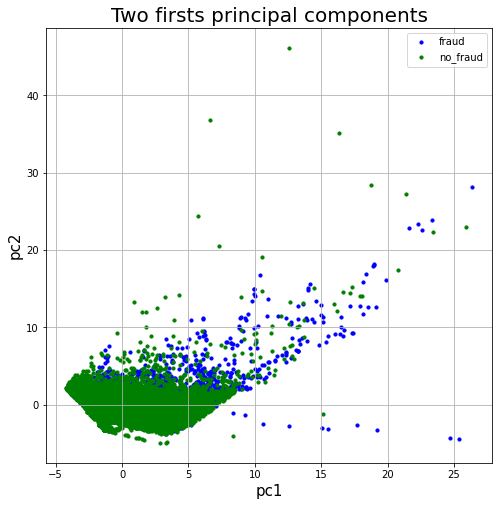

In [49]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('Two firsts principal components', fontsize = 20)
targets = ['fraud', 'no_fraud']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pcdf['target'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()